# Chapter 3: Classification

In [14]:
import numpy as np
import pandas as pd

/root/ryo_iwata/learning/handson-ml/handson_env/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## MNIST Classification

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- `DESCR` describes the dataset
- `data` array with one row few instance and one column per feature
- `target` array with labels

In [4]:
input_array, output_array = mnist["data"], mnist["target"]

In [5]:
input_array.shape

(70000, 784)

In [6]:
output_array.shape

(70000,)

- 784 features(28 * 28 pixels)
- Intensity if from 0 (white) to 255 (black)

# Visualizing the Numbers

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
example_num = input_array[42]

In [10]:
example_num_image = example_num.reshape(28, 28)

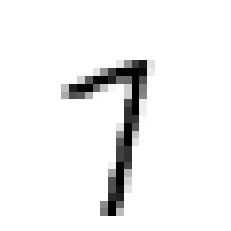

In [11]:
plt.imshow(example_num_image, cmap= mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [13]:
output_array[42]

'7'

- Change the labels to numerical data

In [15]:
output_array = output_array.astype(np.uint8)

# Split the Data

- Data is already shuffled 

In [16]:
X_train, X_test, y_train, y_test = input_array[:60000], input_array[60000:], output_array[:60000], output_array[60000:]

# Training a Binary Classifier

- Creating an identifier that will predict if an image is `8` or not